# start

In [1]:
PRFX='0318_5'
# http://localhost:8081/notebooks/git/recsys20/working/prep0318_1.ipynb
PRFX_PRP = 'prep0318_1' 
langs = ['3A85BCEC571C3F5AB1069E4924189177','515E873C86EE1577E75FA2387B7FA59E',]
trntmstmp=1584412344
valtmstmp=1584405047
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-17 00:30:47']

# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost
import dask_xgboost
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_prp=f'{HOME}/output/{PRFX_PRP}'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]

tgts     = ['Retweet','Reply','Like','RTwCmnt',]
cols_tgt = ['retwt',  'reply','like','retwt_cmmnt',]


dask.__version__ 2.12.0


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/dask/array/random.py:27: FutureWarning: dask.array.random.doc_wraps is deprecated and will be removed in a future version
  FutureWarning,


# prepare data

In [3]:
df = dd.concat([dd.read_csv(f'{p_prp}/dftrn_{lang}_{trntmstmp}__{PRFX_PRP}.tsv',sep='\x01') for lang in langs])

In [4]:
%%time
# https://stackoverflow.com/questions/40376425/dask-dataframe-equivalent-of-pandas-dataframe-sort-values
lendf = df.shape[0].compute()
valsz = int(lendf*0.15)
trnsz = lendf-valsz
lendf, trnsz, valsz

CPU times: user 496 ms, sys: 134 ms, total: 630 ms
Wall time: 591 ms


(45628, 38784, 6844)

In [5]:
%%time
dftr=df.nsmallest(trnsz,'tm')
dfvl=df.nlargest(valsz,'tm')

assert dfvl.tm.min().compute() >= dftr.tm.max().compute()

CPU times: user 1.14 s, sys: 302 ms, total: 1.44 s
Wall time: 1.39 s


In [6]:
dftr.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'reply', 'retwt',
       'retwt_cmmnt', 'like'],
      dtype='object')

In [7]:
cols_feat=[
       'tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2',
]

In [8]:
%%time
X, ys = (df[cols].to_dask_array(lengths=True) for cols in (cols_feat,cols_tgt))

CPU times: user 1.03 s, sys: 246 ms, total: 1.27 s
Wall time: 1.22 s


In [9]:
%%time
Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15, random_state=SEED)

CPU times: user 15.8 ms, sys: 0 ns, total: 15.8 ms
Wall time: 14.9 ms


# train

In [10]:
client = Client()

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [42]:
tgt2params = {
        'Retweet': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
#             'gamma':1,
        }, 
        'Reply': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
            'gamma':1,
        }, 
        'Like': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
#             'gamma':1,
        }, 
        'RTwCmnt': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
#             'gamma':1,
        }, 
}

In [43]:
tgt2bst={}
tgt2col2fscr={}
for i,tgt in enumerate(tgts):
    params = tgt2params[tgt]
    bst = dask_xgboost.train(client, params,
                             Xtrn, ystrn[:,i],
                             num_boost_round=40)
    tgt2bst[tgt]=bst
    print(dtnow(), tgt)
    
    fi2col=dict(zip(bst.feature_names, cols_feat))
    col2fi=dict(zip(cols_feat, bst.feature_names))
    fi2fscr=bst.get_fscore()
    col2fscr={col:fi2fscr.get(fi,0) for col,fi in col2fi.items()}
    tgt2col2fscr[tgt]=col2fscr

pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-18 20:23:33 Retweet
2020-03-18 20:23:43 Reply
2020-03-18 20:23:54 Like
2020-03-18 20:24:04 RTwCmnt


In [44]:
tgt2bst=pickle.load(open(f"{p_out}/tgt2bst.p", "rb"))

Retweet


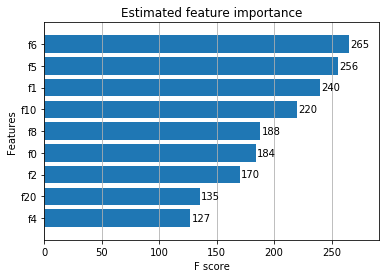

,0,1
6,u2_following_cnt,265
5,u2_follower_cnt,256
1,u1_fllwer_cnt,240
10,len_toks,220
8,u2_create_tm,188
0,tm,184
2,u1_fllwing_cnt,170
20,tmdlta_u2u1,135
4,u1_create_tm,127
22,tmdlta_twtu2,72


Reply


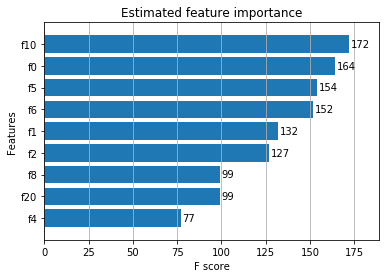

,0,1
10,len_toks,172
0,tm,164
5,u2_follower_cnt,154
6,u2_following_cnt,152
1,u1_fllwer_cnt,132
2,u1_fllwing_cnt,127
20,tmdlta_u2u1,99
8,u2_create_tm,99
4,u1_create_tm,77
22,tmdlta_twtu2,69


Like


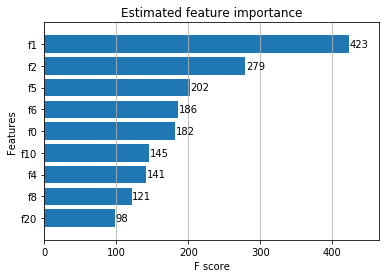

,0,1
1,u1_fllwer_cnt,423
2,u1_fllwing_cnt,279
5,u2_follower_cnt,202
6,u2_following_cnt,186
0,tm,182
10,len_toks,145
4,u1_create_tm,141
8,u2_create_tm,121
20,tmdlta_u2u1,98
21,tmdlta_twtu1,60


RTwCmnt


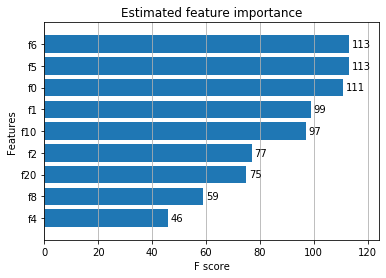

,0,1
5,u2_follower_cnt,113
6,u2_following_cnt,113
0,tm,111
1,u1_fllwer_cnt,99
10,len_toks,97
2,u1_fllwing_cnt,77
20,tmdlta_u2u1,75
8,u2_create_tm,59
4,u1_create_tm,46
22,tmdlta_twtu2,45


In [45]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

for i,tgt in enumerate(tgts):
    print(tgt)
    show_feat_importance(tgt2bst[tgt])
    col2fscr=tgt2col2fscr[tgt]
    display(pd.DataFrame(col2fscr.items()).sort_values(1, ascending=False))

# validate

In [46]:
tgt2ytrn={}
tgt2yval={}
tgt2prdtrn={}
tgt2prdval={}
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt)
    prdtrn = dask_xgboost.predict(client, tgt2bst[tgt], Xtrn).persist()
    prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
    ytrn, prdtrn = dask.compute(ystrn[:,i], prdtrn)
    yval, prdval = dask.compute(ysval[:,i], prdval)
    tgt2ytrn[tgt],tgt2yval[tgt]=ytrn,yval
    tgt2prdtrn[tgt],tgt2prdval[tgt]=prdtrn,prdval

2020-03-18 20:24:06 Retweet
2020-03-18 20:24:07 Reply
2020-03-18 20:24:09 Like
2020-03-18 20:24:11 RTwCmnt


In [47]:
def show_roc_auc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

In [48]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for i,tgt in enumerate(tgts):
    print(tgt)
    ytrn,yval = tgt2ytrn[tgt],tgt2yval[tgt]
    prdtrn,prdval = tgt2prdtrn[tgt],tgt2prdval[tgt]
    scr_rocauc_trn = roc_auc_score(ytrn, prdtrn)
    scr_rocauc_val = roc_auc_score(yval, prdval)
    scr_auc_trn=compute_prauc(prdtrn, ytrn)
    scr_rce_trn=compute_rce(prdtrn, ytrn)
    scr_auc_val=compute_prauc(prdval, yval)
    scr_rce_val=compute_rce(prdval, yval)
    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.8999 valid auc: 0.7784
train prauc: 0.5738 valid auc: 0.2679
train rce: 32.8240 valid rce: 13.9004
Reply
train rocauc: 0.9447 valid auc: 0.7206
train prauc: 0.5407 valid auc: 0.0532
train rce: 38.1986 valid rce: 4.6599
Like
train rocauc: 0.9180 valid auc: 0.8845
train prauc: 0.9192 valid auc: 0.8817
train rce: 44.6802 valid rce: 38.1552
RTwCmnt
train rocauc: 0.9916 valid auc: 0.6778
train prauc: 0.7231 valid auc: 0.0191
train rce: 52.2364 valid rce: 0.4120


In [49]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']

In [50]:
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.573776,32.824,0.540661,38.1986,0.919164,44.6802,0.723053,52.2364
scrval,0.267898,13.9004,0.0531653,4.65989,0.881657,38.1552,0.0191394,0.412013


# infer

In [ ]:
ls {p_prp} | grep {valtmstmp}

In [ ]:
dftst=dd.read_csv(
    f'{p_prp}/dfval_{valtmstmp}__{PRFX_PRP}.tsv',
    sep='\x01',
    encoding='utf8')

In [ ]:
Xtst = dftst[cols_feat].to_dask_array(lengths=True)

In [ ]:
%%time
tgt2prdtst={}
for i,tgt in enumerate(tgts):
    prdtst = dask_xgboost.predict(client, tgt2bst[tgt], Xtst)
    prdtst = prdtst
    tgt2prdtst[tgt]=prdtst 

In [ ]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [ ]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False,single_file=True)

In [ ]:
# %%time
# for tgt in tgts:
#     print(dtnow(), tgt)
#     dfsub = pd.concat(pd.read_csv(o, header=None) for o in sorted(glob.glob(f'{p_out}/{tgt}__{PRFX}_*.csv')))
#     dfsub.to_csv(f'{p_out}/{tgt}__{PRFX}.csv', 
#                           index=False, 
#                           header=False)

In [ ]:
!head -n 2 {p_prp}/val_{valtmstmp}.tsv

In [ ]:
for tgt in tgts:
    !head -n 2 {p_out}/{tgt}__{valtmstmp}__{PRFX}.csv